In [1]:
# For running the notebook on Google Colab, uncomment the following lines of code.

# ! pip install irrCAC

# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/CSMM-pipeline

# Data Annotation

At the beginning of each annotation endeavor stands the development of a valid classification scheme. The goal of a classification scheme is to define the concepts the research engages with and rules for how the concepts can be recongized in text. In general, classification schemes can be developed top-down, i.e. theory-driven, or bottom-up, i.e. data-driven. In a theory-driven approach, researchers form classes based on evidence from the literature. In a data-driven approach the classes are developed through the qualitative inspection of the data, for example by a Grounded Theory or content analysis approach. The choice of the approach mainly depends on how well the concept has been outlined in the literature and whether existing conceptualizations fit the current dataset.

Since this tutorial focusses on code, we will not demonstrate the development of a classification scheme here. Instead, we refer to the accompanying publication (Herderich et al., 2026). The publication also contains notes on composing the annotation team, annotator bias, and LLMs as annotators (see also part two of this tutorial, where we demonstrate how LLMs can be used as classifiers).

However, the sampling strategies shown below can be used to sample data for a data-driven approach to developing the classification scheme.

In this notebook we cover:

1. The sampling of training data, including a strategy to counteract unbalanced training data (Iterative Annotation).
2. Measuring interrater agreement.

## Sampling the Ideal Training Data

### Calculating Interrater Reliability

Interrater agreement is an index for data quality. If annotators tend to agree, the intended concept is measured reliably. There are several interrater reliability (IRR) indices for different use cases, that is number of annotators and classes. A widely used IRR index that generalizes across more than two annotators and classes is Krippendorff's alpha. It was designed to improve upon percentage agreement, a basic index that does not adjust for agreement by chance.

Still, Krippendorff's alpha has disadvantages, too. It assumes (like Conger's kappa and Fleiss' kappa) that raters intentionally annotate as randomly as possible - an assumption that is not very realistic. All three indicators are prone to skewness in the data (i.e., class imbalance) and often underestimate the true agreement.

Gwet’s AC1 and AC2, and the Brennan-Prediger coefficient are alternative IRR measures, that are less prone to skewness in the data. In general, the question remains which level of IRR is sufficient given that factors like task difficulty and annotator diversity drive down agreement.

In the following, we will load a dataset with four labels per tweet to calculate and contrast different IRR indices using the Python package irrCaC.

In [2]:
import pandas as pd
import numpy as np

from irrCAC.raw import CAC

In [3]:
# load the data
multiple_labels = pd.read_csv("data/multiple_labels.csv", sep=";")
multiple_labels.head()

,label_1,label_2,label_3,label_4,text
0,sarc,sarc,sarc,sarc,@realvibes @CoolMaas Also müssen wir erstmal a...
1,construct,opin,opin,construct,@Max_Muller Jetzt: Unsere Schwierigkeiten sind...
2,opin,construct,opin,opin,@user123 @newsflashxyz @daily_report @global_w...
3,opin,opin,opin,opin,". @LenaMeyer Wer Europa festigen will, darf da..."
4,other,other,sarc,other,"@maxmiller @beauty.sight @newsflash Jo, aber e..."


In [4]:
# keep labels only
labels_only = multiple_labels.drop(columns=["text"])

# calculate & print IRR
cac = CAC(labels_only)

for index, func in zip(["Krippendorff's alpha", "Fleiss' kappa", "Conger's kappa", "Brennan-Prediger", "GWET's AC1"],
                       [cac.krippendorff(), cac.fleiss(), cac.conger(), cac.bp(), cac.gwet()]):
    print(f"{index}: {round(func['est']['coefficient_value'], 2)}")

Krippendorff's alpha: 0.43
Fleiss' kappa: 0.43
Conger's kappa: 0.43
Brennan-Prediger: 0.45
GWET's AC1: 0.45


In [5]:
# manually compute percentage agreement
agree = pd.DataFrame(columns = ['label_1/label_2', 'label_1/label_3', 'label_1/label_4',
                                'label_2/label_3', 'label_2/label_4', 'label_3/label_4', 'frac'])

# compute binary agreement between pairs of raters
for comb in ['label_1/label_2', 'label_1/label_3', 'label_1/label_4', 'label_2/label_3', 'label_2/label_4', 'label_3/label_4']:
    x = []
    for i in range(len(labels_only)):
        if labels_only[comb[:7]].iloc[i] == labels_only[comb[-7:]].iloc[i]:
            x.append(1)
        else:
            x.append(0)
    agree[comb] = x

# calculate mean agreement over pairs of raters per tweet
agree['frac'] = agree.mean(axis=1)

# percentage agreement is average mean agreement over all tweets
print(f"Percentage agreement: {round(agree['frac'].mean(), 2)} \n")

Percentage agreement: 0.56 



### Sampling Strategies for Training Data

Samples in the corpus could be unevenly distributed across relevant confounding factors. In our example, tweets stem from different years (2015 to 2018) and from users being associated with a dedicated hate group, counter speech group, or neutral users. Sampling uniformly from the corpus for annotation can introduce bias to the labels since we are not capturing the constructs in their entirety. Furthermore, when less data from underrepresented confounding variables is presented to the classifier, it will automatically perform worse for said groups.

To counteract this effect, data can be subdivided into a number of bins and the training data can be composed by sampling the same number of examples from each bin, which we will demonstrate below.

In [6]:
import matplotlib.pyplot as plt

In [7]:
sample_pool = pd.read_csv("data/sample_pool.csv", sep=";")
sample_pool.head()

,tweet_id,text,hate_score,year,counter_score
0,960158527582097408,Das ist so nicht richtig.,0.737982,2017,0.262018
1,837717128480444418,Man sollte die Drohungen von der ISIS Gruppe e...,0.299734,2017,0.700266
2,1082375206319128576,Gerade gibt's in den USA eine Ausschreibung fü...,0.124318,2017,0.875682
3,1013645930443235328,Horst los! Das Netz hat dein Angebot voll ange...,0.318200,2017,0.681800
4,1031345564649172992,Und was jetzt? Müssen wir uns jetzt neben dem ...,0.671718,2015,0.328282


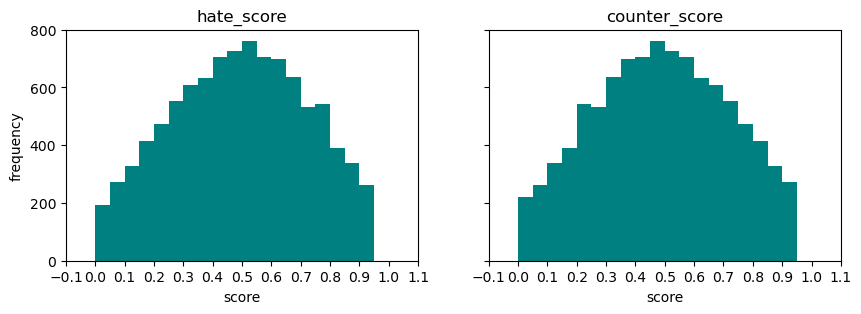

In [8]:
# visualize distribution of hate and counter scores
# Note: The scores have been randomly sampled for demonstration purposes
# and do not reflect the scores of the real data!
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

for ax, var in zip(axs, ["hate_score", "counter_score"]):
    ax.hist(sample_pool[var], bins=np.arange(0, 1, 0.05), color="teal")
    ax.set_xticks(np.arange(-0.1, 1.1, 0.1))
    ax.set_xlabel("score")
    ax.set_title(f"{var}")

axs[0].set_ylabel("frequency")
plt.show()

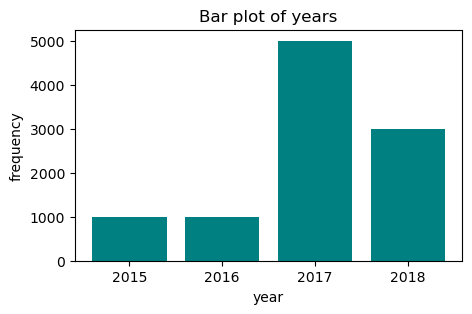

In [9]:
# visualize distribution of years
fig = plt.figure(figsize=(5,3))
plt.bar(sample_pool.year.value_counts().keys(), sample_pool.year.value_counts().values, color="teal")
plt.xticks([2015, 2016, 2017, 2018])
plt.xlabel("year")
plt.ylabel("frequency")
plt.title("Bar plot of years")
plt.show()

We can see that hate scores, counter scores, as well as years are distributed unevenly in our dataset. Let's assume, we would like to draw 400 tweets for another round of annotation. This sample is supposed to consist of 25% of each year (n=100), and 40% hate speakers (n=160), 40% counter speakers (n=160), and 40% neutral users (n=80). Contrary to the prevalence in the dataset, we decide to oversample hate and counter speakers since they are more relevant to our research question.

In [10]:
# First, let's divide our corpus into hate speakers, counter speakers and neutral users.
# The hate score and counter scores both range between 0 and 1.
# To be confident in our choices, we are setting the thresholds like so:
# Hate speakers: >= 0.8
# Counter speakers: >= 0.8
# Neutral users: >= 0.45 and <= 0.55 (of hate score)
hate_df = sample_pool[sample_pool.hate_score >= 0.8]
counter_df = sample_pool[sample_pool.counter_score >= 0.8]
neutral_df = sample_pool[(sample_pool.hate_score >= 0.45) & (sample_pool.hate_score <= 0.55)]

In [11]:
# We define helper functions to create our sample.
def get_tweets_by_year(df, year=2015, sample_size=None, seed=None):
    """ filters the dataframe for year 'year' and samples 'sample_size' tweets from it """
    df = df[df.year==year]
    if sample_size:
        return df.sample(n=sample_size, random_state=seed)
    else:
        return df

def create_sample(hate_df, counter_df, neutral_df, sample_size=10, 
                  neutral_sample_size=1, seed=None):
    """ Concatenates hate speakers, counter speakers and neutral users' dataframes per year while sampling
        'sample_size' hate and counter speakers, and 'neutral_sample_size' neutral users """
    frames = []
    for year in [2015, 2016, 2017, 2018]:
        frames += [
            get_tweets_by_year(hate_df, year=year, sample_size=sample_size, seed=seed),
            get_tweets_by_year(counter_df, year=year, sample_size=sample_size, seed=seed),
            get_tweets_by_year(neutral_df, year=year, sample_size=neutral_sample_size, seed=seed)
        ]
    
    df = pd.concat(frames)    
    return(df)

In [12]:
# Now we create our sample.
# Sample size is set to 40, because 40% hate/counter speakers per 100 tweets (per year) = 40.
# Neutral sample size is set to 20, because 20% neutral users per 100 tweets (per year) = 20.
annotation_sample = create_sample(hate_df, counter_df, neutral_df, sample_size=40, neutral_sample_size=20, seed=15)

In [13]:
# Let's do a sanity check:
annotation_sample.year.value_counts()

year
2015    100
2016    100
2017    100
2018    100
Name: count, dtype: int64

In [14]:
print(f"Hate speakers: {len(annotation_sample[annotation_sample.hate_score >= 0.8])}")
print(f"Counter speakers: {len(annotation_sample[annotation_sample.hate_score >= 0.8])}")
print(f"Neutral users: {len(annotation_sample[(annotation_sample.hate_score >= 0.45) & (annotation_sample.hate_score <= 0.55)])}")

Hate speakers: 160
Counter speakers: 160
Neutral users: 80


This sampling strategy - stratified sampling based on confounding variables - can also be applied to the held-out test set to ensure that all classes are tested equally for the final performance measurement.

## Focus Unbalanced Training Data: Iterative Annotation

Similar to confounding variables, imbalances in the classes that the machine learning model is supposed to predict are problematic, because the classifier will struggle to pick up minority classes during training. Here, we present a new annotation procedure, <b>Iterative Annotation</b>, that counteracts class imbalances in the training data. While other sampling strategies can only be applied post hoc after the annotations have already been collected, Iterative Annotation can be applied during the annotation process effectively incorporating more information from the corpus than sampling strategies based on data augmentation alone (e.g., random oversampling or synthetic minority oversampling).

In the example below, we load our sample pool of tweets from which we want to draw tweets for the annotators to label. We want to overrepresent the minority class in the sampled tweets, therefore we use a preliminary classifier, a support vector machine, that was trained on already labeled tweets to classify all tweets in the sample pool and oversample tweets that the preliminary classifier has classified as the minority class.

The process of Iterative Annotation is illustrated below.

<img src="https://raw.githubusercontent.com/Hai-Lina/computational-social-mixed-methods-pipelines/GESIS-methods-hub/figures/iterative-annotation.png" width="500">

In [15]:
import os
import re
from pathlib import Path
from joblib import load

In [16]:
# load the data from which we can sample
# This is data without labels.
src = "data"
fname = "sample_pool.csv"
sample_pool = pd.read_csv(Path(src, fname), dtype={"tweet_id":str}, sep=";")
sample_pool.head()

,tweet_id,text,hate_score,year,counter_score
0,960158527582097408,Das ist so nicht richtig.,0.737982,2017,0.262018
1,837717128480444418,Man sollte die Drohungen von der ISIS Gruppe e...,0.299734,2017,0.700266
2,1082375206319128576,Gerade gibt's in den USA eine Ausschreibung fü...,0.124318,2017,0.875682
3,1013645930443235328,Horst los! Das Netz hat dein Angebot voll ange...,0.318200,2017,0.681800
4,1031345564649172992,Und was jetzt? Müssen wir uns jetzt neben dem ...,0.671718,2015,0.328282


In [17]:
# To classify the tweets in our corpus with a support vector machine as preliminary classifier,
# we first need to clean the tweet text.

# remove URLs
sample_pool["text_clean"] = sample_pool["text"]\
    .apply(lambda x: re.sub(r"https?:\/\/\S*", "", x, flags=re.MULTILINE))

# lowercase all text
sample_pool["text_clean"] = sample_pool["text"]\
    .apply(lambda x: x.lower())

sample_pool.head()

,tweet_id,text,hate_score,year,counter_score,text_clean
0,960158527582097408,Das ist so nicht richtig.,0.737982,2017,0.262018,das ist so nicht richtig.
1,837717128480444418,Man sollte die Drohungen von der ISIS Gruppe e...,0.299734,2017,0.700266,man sollte die drohungen von der isis gruppe e...
2,1082375206319128576,Gerade gibt's in den USA eine Ausschreibung fü...,0.124318,2017,0.875682,gerade gibt's in den usa eine ausschreibung fü...
3,1013645930443235328,Horst los! Das Netz hat dein Angebot voll ange...,0.318200,2017,0.681800,horst los! das netz hat dein angebot voll ange...
4,1031345564649172992,Und was jetzt? Müssen wir uns jetzt neben dem ...,0.671718,2015,0.328282,und was jetzt? müssen wir uns jetzt neben dem ...


In [18]:
# Please note: We do not demonstrate the training of the support vector machine
# (preliminary classifier) here. Assume, we've previously trained the SVM as described above.

# The preliminary classifier is actually two classifiers – each trained on 4000
# annotations from one of two annotators (AS and LT, "ensemble prediction"). 
# We load both classifiers as well as the embedding model (TFIDF) here.
raters = ["AS", "LT"]
classifier_src = "finetuned_models"
classifier_model = "LinearSVC"
embedding = "TfidfVectorizer"

classifiers = {rater:{} for rater in raters}
for rater in raters:
    tfidf = load(Path(classifier_src, embedding, f"rater_{rater}.joblib"))
    clf = load(Path(classifier_src, classifier_model, f"rater_{rater}.joblib")) 
    classifiers[rater]["embedding"] = tfidf
    classifiers[rater]["classifier"] = clf

# Note on Inconsistent Version Warning: The SVM classifier might not make accurate 
# predicitons when the scikit-learn versions at training and use differ. This is
# irrelevant for illustration purposes, but becomes important in production.

/Users/alinaherderich/anaconda3/envs/CSMM-pipeline/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/alinaherderich/anaconda3/envs/CSMM-pipeline/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.0.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/alinaherderich/anaconda3/envs/CSMM-pipeline/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Tr

In [19]:
# We use both preliminary classifiers to create predictions for each of the
# examples in the sample pool.
for rater in raters:
    X = classifiers[rater]["embedding"].transform(sample_pool["text_clean"]).toarray()
    pred = classifiers[rater]["classifier"].predict(X)
    sample_pool[f"pred_{rater}"] = pred

sample_pool.head()

,tweet_id,text,hate_score,year,counter_score,text_clean,pred_AS,pred_LT
0,960158527582097408,Das ist so nicht richtig.,0.737982,2017,0.262018,das ist so nicht richtig.,1,1
1,837717128480444418,Man sollte die Drohungen von der ISIS Gruppe e...,0.299734,2017,0.700266,man sollte die drohungen von der isis gruppe e...,1,1
2,1082375206319128576,Gerade gibt's in den USA eine Ausschreibung fü...,0.124318,2017,0.875682,gerade gibt's in den usa eine ausschreibung fü...,1,1
3,1013645930443235328,Horst los! Das Netz hat dein Angebot voll ange...,0.318200,2017,0.681800,horst los! das netz hat dein angebot voll ange...,2,2
4,1031345564649172992,Und was jetzt? Müssen wir uns jetzt neben dem ...,0.671718,2015,0.328282,und was jetzt? müssen wir uns jetzt neben dem ...,4,4


In [20]:
# We retain only entries for which both classifiers agree.
sample_pool = sample_pool[sample_pool[[f"pred_{rater}" for rater in raters]]\
            .apply(lambda x: len(set(x.values)) == 1, axis=1)]
sample_pool = sample_pool.drop(columns=[f"pred_{rater}" for rater in raters][1:] + ["text_clean"])
sample_pool = sample_pool.rename(columns={f"pred_{raters[0]}": "pred"})  
sample_pool.head()

,tweet_id,text,hate_score,year,counter_score,pred
0,960158527582097408,Das ist so nicht richtig.,0.737982,2017,0.262018,1
1,837717128480444418,Man sollte die Drohungen von der ISIS Gruppe e...,0.299734,2017,0.700266,1
2,1082375206319128576,Gerade gibt's in den USA eine Ausschreibung fü...,0.124318,2017,0.875682,1
3,1013645930443235328,Horst los! Das Netz hat dein Angebot voll ange...,0.318200,2017,0.681800,2
4,1031345564649172992,Und was jetzt? Müssen wir uns jetzt neben dem ...,0.671718,2015,0.328282,4


In [21]:
# This is how the distribution of predicted labels in the remaining sample pool looks like.
sample_pool["pred"].value_counts()

pred
1    2714
0    1633
3    1274
2    1114
4     661
5      65
Name: count, dtype: int64

In [22]:
# We want to bias the sampling towards class "0", which contains all the
# constructive counter speech strategies.
id_to_label = {
    0:"construct",
    1:"opin",
    2:"sarc",
    3:"other",
    4:"unint",
    5:"foreign"
}

# Therefore we retain only the 1633 examples that were classified as
# "construct" by the preliminary classifier.
sample_pool["pred_label"] = sample_pool["pred"].replace(id_to_label)
sample_pool = sample_pool[sample_pool["pred_label"] == "construct"]

sample_pool.head()

,tweet_id,text,hate_score,year,counter_score,pred,pred_label
13,894138148686573568,"Thema Völkerrecht: Irak-Krieg, Libyen, Guantán...",0.490275,2018,0.509725,0,construct
18,1025077251258368000,Leeres Gerede! Nur eine einzige Nation gibt un...,0.574163,2018,0.425837,0,construct
29,1076480651044503552,"Es wird Zeit, die „romantische Idee“ loszulass...",0.419885,2017,0.580115,0,construct
33,882150372592234496,Jetzt ham wa alle ma was kapiert: was politisc...,0.460919,2017,0.539081,0,construct
36,912209524123213829,"Hahaha, die werden sowieso zusammenarbeiten. H...",0.083977,2015,0.916023,0,construct


In [23]:
# Finally, we draw a sample of 1000 examples from the remaining pool ...
sample_size = 1000
seed = 42  # for reproducibility
sample = sample_pool.sample(n=sample_size, random_state=seed).reset_index(drop=True)
sample = sample[["tweet_id", "text"]]

# ... and save it to a file for annotators to label.
fname = "biased_sample.csv"
sample.to_csv(Path(src, fname), index=False)
sample.head()

# Because our preliminary classifier (the support vector machine) still has low
# performance, the sample that was only labeled as "construct" by this classifier
# will still contain enough of the majority classes to result in a balanced sample.

,tweet_id,text
0,1021094619222822913,Warum sollen AfD-Wähler rausgeekelt werden? Bi...
1,1007198873130078208,Deutschlandweite STASI-Aktion gegen freie Mein...
2,1046681052557848576,Schon mal was von Urheberrechtsverletzung gehö...
3,1060921392118620160,"Das ist voll das Standard-Ding in der Politik,..."
4,813671235158687744,Populismus bei den Mossad-Medien! @newsflash12...


Once the new sample of tweets has been labeled by the annotators, it can be used together with the previously annotated data to improve the preliminary classifier to sample new tweets for annotation.

We illustrate the effect of Iterative Annotation below. In our working example, classes sarcasm (sarc), constructive comments (construct), and leaving factual discussion (leave fact) were infrequent, at least in the beginning (batch 1). With each round of Iterative Annotation, those minority classes increased, while at the same time classes irrelevant to our research question (other) decreased.

<img src="https://raw.githubusercontent.com/Hai-Lina/computational-social-mixed-methods-pipelines/GESIS-methods-hub/figures/iterative-annotation-effect.png" width="500">

<b>To continue with the tutorial, please refer to notebook "2_model_training".</b>